In [39]:
# =============== Setup ===============
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42

In [49]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\data\telco_churn.csv", na_values=["", " ", "NA", "N/A", "?", "null", "None"])
import io

def info_text(df):
    buf = io.StringIO()
    df.info(buf=buf)
    return buf.getvalue()

print("=== Telco df.info() ===")
print(info_text(df))

=== Telco df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

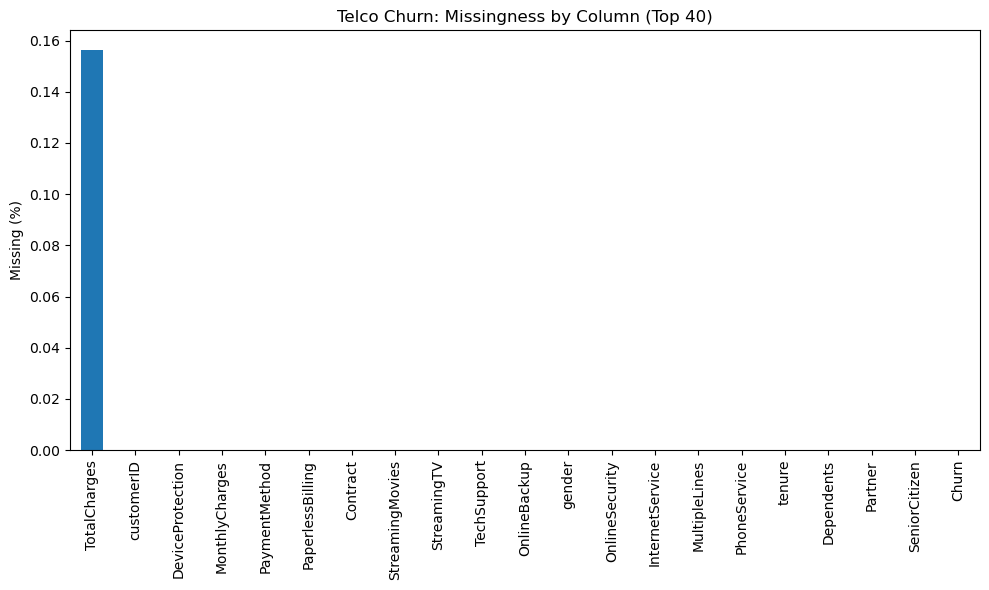

In [59]:
import matplotlib.pyplot as plt
# Make TotalCharges numeric so blanks become NaN
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    
def plot_missing_bar(df, title, savepath=None, top_n=40):
    # Compute % missing
    miss_pct = df.isna().mean().sort_values(ascending=False) * 100
    # Keep top_n longest bars 
    miss_pct = miss_pct.head(top_n)
    
    plt.figure(figsize=(10, 6))
    miss_pct.plot(kind="bar")
    plt.ylabel("Missing (%)")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

# Telco bar
plot_missing_bar(df, "Telco Churn: Missingness by Column (Top 40)", 
                 savepath="telco_missing_bar.png")


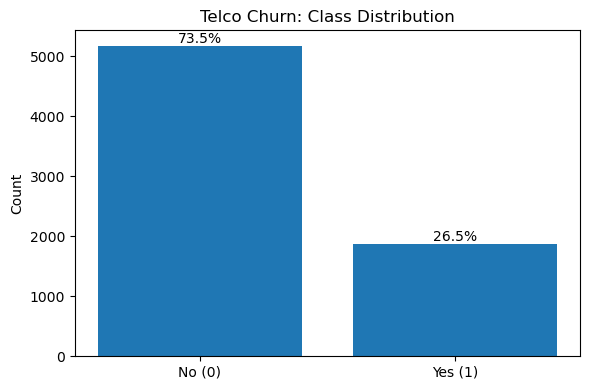

In [63]:
# =============== Load ===============
target = "Churn"  # "Yes"/"No" -> 1/0
df[target] = (df[target].astype(str).str.lower().str.strip() == "yes").astype(int)

# ----- Churn Class Distribution -----
counts = df[target].value_counts().sort_index()  # index: 0,1
labels = ["No (0)", "Yes (1)"]
vals = [counts.get(0, 0), counts.get(1, 0)]
total = sum(vals)
pct = [v / total * 100 if total > 0 else 0 for v in vals]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals)
plt.title("Telco Churn: Class Distribution")
plt.ylabel("Count")

# annotate percentages on top of bars
for b, p in zip(bars, pct):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(),
             f"{p:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

y = df[target].values
X = df.drop(columns=[target])

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()


In [82]:
# =============== CV & Metrics ===============
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "ROC_AUC": "roc_auc",
    "PR_AUC":  "average_precision",
    "F1_pos":  "f1",   # default pos_label=1 for binary 0/1
}

def evaluate(pipe, name):
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n{name}:")
    for k in ["test_ROC_AUC", "test_PR_AUC", "test_F1_pos"]:
        arr = res[k]
        print(f"  {k[5:]}: {arr.mean():.4f} ± {arr.std():.4f}")

# =============== Traditional: Logistic Regression ===============
pre_lr = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=10))]), cat_cols)
])

lr = Pipeline([
    ("prep", pre_lr),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced",
                                 solver="lbfgs", random_state=RANDOM_STATE))
])

# =============== Deep: MLPClassifier + SMOTENC (fixed indices) ===============
# Impute raw columns (no encoding yet)
imp_raw = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", SimpleImputer(strategy="most_frequent"), cat_cols)
], remainder="drop")

n_num = len(num_cols)
n_cat = len(cat_cols)

# Indices for categorical features in the array output by `imp_raw`
cat_idx_for_smote = list(range(n_num, n_num + n_cat))
print("SMOTENC categorical indices:", cat_idx_for_smote[:10], "... total:", len(cat_idx_for_smote))

# Sanity check: confirm `imp_raw` outputs columns in the expected order [num..., cat...]
imp_raw.fit(X)                 # fit imputers only
X_imp = imp_raw.transform(X[:5])  # small sample to inspect shape quickly
assert X_imp.shape[1] == n_num + n_cat, "Unexpected column count after imp_raw"
print(f"imp_raw produced array with shape {X_imp.shape} -> [0:{n_num})=num, [{n_num}:{n_num+n_cat})=cat")

# Optional: printable schematic for your report/logs (truncates lists for readability)
print(f"""
D2 schematic (after imp_raw):
  positions 0..{n_num-1}     -> numeric:     {num_cols[:5]}{'...' if n_num > 5 else ''}
  positions {n_num}..{n_num+n_cat-1} -> categorical: {cat_cols[:5]}{'...' if n_cat > 5 else ''}

Resampling occurs on this raw array with:
  SMOTENC(categorical_features=cat_idx_for_smote, ...)

Encoding (OHE) and scaling occur AFTER SMOTE.
""")


# SMOTENC categorical indices are:
cat_idx_for_smote = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

smote = SMOTENC(categorical_features=cat_idx_for_smote,
                random_state=RANDOM_STATE, k_neighbors=5)

# OHE + scaling (MLP needs scaling)
enc_scale = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler())]), list(range(len(num_cols)))),
    # OneHotEncoder will operate on categorical positions that FOLLOW the nums
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10),
            list(range(len(num_cols), len(num_cols) + len(cat_cols))))
], remainder="drop")

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=512,
    learning_rate_init=1e-3,
    max_iter=250,
    early_stopping=True,
    n_iter_no_change=12,
    random_state=RANDOM_STATE,
    verbose=False
)

pipe_mlp = ImbPipeline([
    ("imp_raw", imp_raw),        # impute raw
    ("smote", smote),            # balance using correct categorical indices
    ("enc_scale", enc_scale),    # OHE (cats) + scale (nums)
    ("clf", mlp_clf)
])

# -----(Classification): MLP+SMOTENC best params & CV trace -----
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone

# Stratified subset (keep class ratio)
def stratified_subsample_binary(X, y, frac=0.4, seed=42):
    rng = np.random.RandomState(seed)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    k_pos = max(1, int(len(idx_pos) * frac))
    k_neg = max(1, int(len(idx_neg) * frac))
    keep = np.r_[rng.choice(idx_pos, size=k_pos, replace=False),
                 rng.choice(idx_neg, size=k_neg, replace=False)]
    keep.sort()
    return X.iloc[keep].reset_index(drop=True), y[keep]

X_search, y_search = stratified_subsample_binary(X, y, frac=0.4, seed=RANDOM_STATE)

# 3-fold CV for the search 
cv_search = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# TEMP speed-ups ONLY for search:
#    - increase OHE min_frequency to reduce columns
#    - reduce SMOTE sampling so it creates fewer synthetic samples
pipe_search = clone(pipe_mlp)
pipe_search.set_params(
    enc_scale__cat__min_frequency=50,    # wider buckets -> fewer OHE cols
    smote__sampling_strategy=0.6         # minority after SMOTE = 60% of majority
)

# Smaller grid + fewer trials
param_dist_mlp_smote_fast = {
    "clf__hidden_layer_sizes": [(256,128,64), (256,128), (128,64)],
    "clf__alpha": [1e-5, 1e-4, 1e-3],
    "clf__learning_rate_init": [5e-4, 1e-3],
    "clf__batch_size": [256, 512],
    "smote__k_neighbors": [3, 5]
}

search_mlp_smote = RandomizedSearchCV(
    estimator=pipe_search,
    param_distributions=param_dist_mlp_smote_fast,
    n_iter=8,                           # was 20
    cv=cv_search,                       # 3-fold
    scoring="average_precision",        # PR-AUC
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
    return_train_score=False
)

print("\n[FAST Search] MLP+SMOTENC on 40% subset, 3-fold ...")
search_mlp_smote.fit(X_search, y_search)
print("\n[Best Params - fast]:", search_mlp_smote.best_params_)
print(f"[Best CV PR-AUC - fast] {search_mlp_smote.best_score_:.4f}")

cv_df = pd.DataFrame(search_mlp_smote.cv_results_).sort_values("rank_test_score")

# Rebuild pipeline:
best = search_mlp_smote.best_params_
keep_keys = ["clf__hidden_layer_sizes", "clf__alpha", "clf__learning_rate_init",
             "clf__batch_size", "smote__k_neighbors"]
best_final = {k: v for k, v in best.items() if k in keep_keys}

pipe_final = clone(pipe_mlp).set_params(**best_final)

print("\n[Final Eval] MLP+SMOTENC (fast-searched params) on FULL data, 5-fold ...")
evaluate(pipe_final, "MLP+SMOTENC (fast-searched params)")

SMOTENC categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13] ... total: 16
imp_raw produced array with shape (5, 20) -> [0:4)=num, [4:20)=cat

D2 schematic (after imp_raw):
  positions 0..3     -> numeric:     ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
  positions 4..19 -> categorical: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService']...

Resampling occurs on this raw array with:
  SMOTENC(categorical_features=cat_idx_for_smote, ...)

Encoding (OHE) and scaling occur AFTER SMOTE.


[FAST Search] MLP+SMOTENC on 40% subset, 3-fold ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

[Best Params - fast]: {'smote__k_neighbors': 3, 'clf__learning_rate_init': 0.0005, 'clf__hidden_layer_sizes': (256, 128), 'clf__batch_size': 256, 'clf__alpha': 1e-05}
[Best CV PR-AUC - fast] 0.6468

[Final Eval] MLP+SMOTENC (fast-searched params) on FULL data, 5-fold ...

MLP+SMOTENC (fast-searched params):
  ROC_AUC: 0.8126 ± 0.0196
  PR_AUC: 0.6002 ± 0.0297


In [83]:
evaluate(lr,       "LogReg (class_weight) [Traditional]")
evaluate(pipe_mlp, "MLPClassifier + SMOTENC [Deep]")


LogReg (class_weight) [Traditional]:
  ROC_AUC: 0.8449 ± 0.0135
  PR_AUC: 0.6550 ± 0.0274
  F1_pos: 0.6218 ± 0.0107

MLPClassifier + SMOTENC [Deep]:
  ROC_AUC: 0.8133 ± 0.0068
  PR_AUC: 0.6024 ± 0.0170
  F1_pos: 0.5842 ± 0.0199


[PR-AUC/AP] 0.5928
[Best threshold by F1] 0.3694  (P=0.514, R=0.711, F1=0.596)


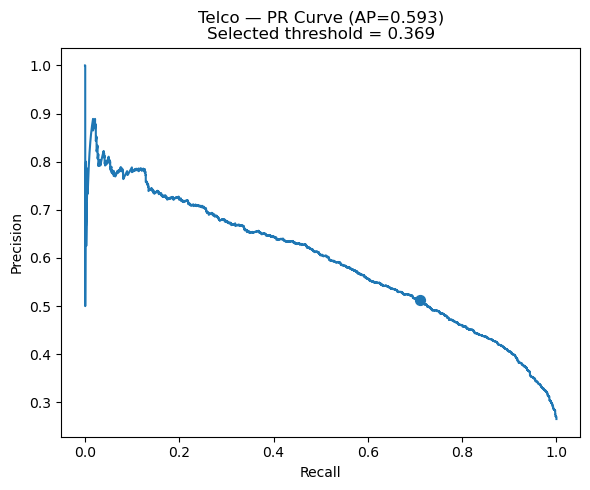

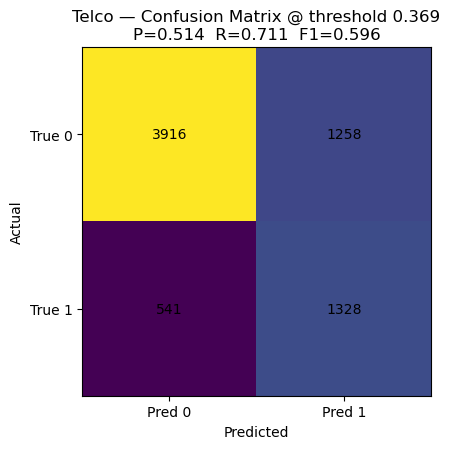

In [89]:
# ----- PR curve + tuned-threshold confusion matrix (OOF) -----
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, confusion_matrix

model_for_plots = pipe_mlp   

# Get OUT-OF-FOLD predicted probabilities
proba_oof = cross_val_predict(
    model_for_plots,
    X, y,
    cv=cv,
    n_jobs=-1,
    method="predict_proba"
)[:, 1]

# PR curve + best F1 threshold
prec, rec, thr = precision_recall_curve(y, proba_oof)
ap = average_precision_score(y, proba_oof)

# Compute F1 for each threshold point ,length len(prec)-1
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
best_p, best_r, best_f1 = prec[best_idx], rec[best_idx], f1s[best_idx]

print(f"[PR-AUC/AP] {ap:.4f}")
print(f"[Best threshold by F1] {best_thr:.4f}  (P={best_p:.3f}, R={best_r:.3f}, F1={best_f1:.3f})")

# PR curve with the selected point marked
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.scatter(best_r, best_p, s=50)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Telco — PR Curve (AP={ap:.3f})\nSelected threshold = {best_thr:.3f}")
plt.tight_layout()
plt.show()

# Confusion matrix at tuned threshold
y_pred_oof = (proba_oof >= best_thr).astype(int)
cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5.2, 4.6))
plt.imshow(cm, aspect="equal")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Telco — Confusion Matrix @ threshold {best_thr:.3f}\n"
          f"P={best_p:.3f}  R={best_r:.3f}  F1={best_f1:.3f}")
plt.tight_layout()
plt.show()